In [33]:
from requests import get
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn-deep')
metric = 'ndcg'
cutoff = 10
n_questions = 5
de_only = True
experiment_subset = 'uniform'
highlight = ['collab']

data = get(f'https://mindreader.tech/spectate/results/{experiment_subset}/{metric}/{cutoff}').json()
data = {k: v for k, v in data.items() if not 'grid' in k}

metric = metric.replace('cov', 'div') if metric == 'cov' else metric  # Hack job :-)
interviewer_kinds = ['greedy-adaptive-', 'greedy-', 'pop-'] #, 'dqn-', 'ddpg-']

def replace_all(string, lst):
    for item in lst:
        string = string.replace(item, '')
    
    return string

unique_models = set([replace_all(model, interviewer_kinds) for model in data.keys()])
if de_only:
    unique_models = set([model.replace('-rec', '') for model in unique_models])
else:
    unique_models = set([model for model in unique_models if model.endswith('-rec')])

print(unique_models)
unique_models = sorted(set([model for model in unique_models if all([f'{interviewer}{model}' in data for interviewer in interviewer_kinds])]))
print(unique_models)
unique_models = ['knn', 'mf', 'ppr-joint', 'ppr-collab', 'ppr-kg', 'ppr-linear-learned']
# Hack job again
interviewer_kinds += ['dqn-', 'ddpg-']

{'fmf', 'dqn-knn', 'random', 'ppr-linear-joint-learned', 'ppr-kg', 'top-pop', 'lrmf', 'dqn-ppr-joint', 'ddpg-mf', 'ddpg-ppr-joint', 'ppr-collab', 'ppr-joint', 'ppr-linear-learned', 'mf', 'knn', 'ddpg-knn', 'melu', 'dqn-mf'}
['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-kg', 'ppr-linear-learned']


ddpg-knn [[0.22813070708163805, 0.2934818450430964, 0.2996117830702579, 0.32777596777633633]]
ddpg-mf [[0.37936122201468553, 0.35830114525823353, 0.35726171477009766, 0.39818147124482456]]
ddpg-ppr-joint [[0.3478628944394666, 0.3254065722389469, 0.3210896345899705, 0.35895026173252087]]
['collab']
Rectangle(xy=(-0.075, 0), width=0.15, height=0.34119, angle=0)
Rectangle(xy=(0.925, 0), width=0.15, height=0.374216, angle=0)
Rectangle(xy=(1.925, 0), width=0.15, height=0.364655, angle=0)
Rectangle(xy=(3.925, 0), width=0.15, height=0.224345, angle=0)
Rectangle(xy=(4.925, 0), width=0.15, height=0.39166, angle=0)
Rectangle(xy=(0.075, 0), width=0.15, height=0.33155, angle=0)
Rectangle(xy=(1.075, 0), width=0.15, height=0.374216, angle=0)
Rectangle(xy=(2.075, 0), width=0.15, height=0.373836, angle=0)
Rectangle(xy=(4.075, 0), width=0.15, height=0.231687, angle=0)
Rectangle(xy=(5.075, 0), width=0.15, height=0.384616, angle=0)
Rectangle(xy=(0.225, 0), width=0.15, height=0.343528, angle=0)
Rectangle(

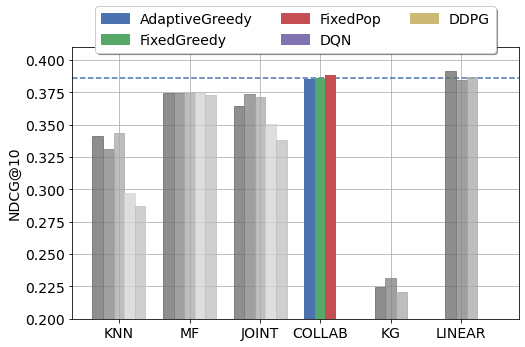

In [34]:
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_rel

fig_width = 8  # Increase if bars become to small to see 
fig_height = 5
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ind = np.arange(len(unique_models))
bar_group_width = .15

model_map = {'ppr-linear-learned': 'linear', 'ppr-joint': 'joint', 'ppr-collab': 'collab', 'ppr-kg': 'kg'}
label_map = {'greedy-adaptive-': 'AdaptiveGreedy', 'greedy-': 'FixedGreedy', 'pop-': 'FixedPop', 'dqn-': 'DQN', 'ddpg-': 'DDPG'}

legend_handles = []

statistical_significances = []

plt.axhline(y=np.mean(data['top-pop'][n_questions - 1]), linestyle='--')
def pad_to_length(lst, l): 
    if len(lst) < l: 
        remaining = len(lst) - l
        [lst.append(lst[-1]) for _ in range(remaining)]
        
    return lst


bars_list = list()
# Add bar sets
for idx, kind in enumerate(interviewer_kinds):
    
    def model_str(kind, model, rec): 
        return f'{kind}{model}-rec' if rec else f'{kind}{model}'
    
    des = []
    res = []
    
    for model in unique_models: 
        ms = model_str(kind, model, False)
        ms_rec = model_str(kind, model, True)
        
        if ms in data:
            if 'ddpg' in ms: 
                print(ms, data[ms])
            if len(data[ms]) == n_questions: 
                des.append(data[ms][n_questions - 1])
            else: 
                des.append(data[ms][-1])
                
        else: 
            des.append(np.zeros((len(unique_models), 4)))
            
        if ms_rec in data: 
            if len(data[ms_rec]) == n_questions: 
                res.append(data[ms_rec][n_questions - 1])
            else: 
                res.append(data[ms_rec][-1])
                
        else: 
            res.append(np.zeros((len(unique_models), 4)))
    
    # des = [data[model_str(kind, model, False)][n_questions - 1] if model_str(kind, model, False) in data else np.zeros((len(unique_models), 4)) for model in unique_models]
    # res = [data[model_str(kind, model, True)][n_questions - 1] if model_str(kind, model, True) in data else np.zeros((len(unique_models), 4)) for model in unique_models]
        
    # Descriptive entity interview performance
    y = [np.mean(de) for de in des]
    y_std = [np.std(de) for de in des]
    
    # Recommendable entity interview performance
    y_rec = [np.mean(re) for re in res]
    y_rec_std = [np.std(re) for re in res]
    
    # Calculate indentation
    bar_width_fraction = 0.7  # Decrease to increase spacing between bar pairs - 0.5 leaves no space 
    bar_width = bar_group_width * bar_width_fraction
    descriptive_indent = ind + idx * bar_group_width
    recommendable_indent = descriptive_indent + bar_width
    
    # Check for statistical significant change
#     for de, re in zip(des, res): 
#         t, p_value = ttest_rel(de, re)
#         statistical_significances.append(p_value <= 0.05)
            
    # Create bar pairs
    bars_list.append(ax.bar(descriptive_indent, y, width=bar_group_width, color=f'C{idx}', zorder=3))
    #ax.bar(recommendable_indent, y_rec, alpha=0.6, width=bar_width, zorder=3, 
    #       yerr=y_rec_std, color=f'C{idx}', ecolor=(0,0,0,0.5), 
    #       edgecolor='white', linewidth=0, hatch='\\\\\\')
            
    # Store the legend handles so we can add some more manually later
    legend_handles.append(mpatches.Patch(color=f'C{idx}', label=label_map.get(kind)))
    

# Add outline if there is statistical significance
children = ax.get_children()

# Error bars are the first children, so skip those
# n_error_bar_sets = n_interviewer_kinds * 2
# n_to_skip = n_error_bar_sets


# n_interviewer_kinds = len(interviewer_kinds)
# n_models = len(unique_models)
# n_bars = (n_models * n_interviewer_kinds)

# bar_pair_indices = []

# for i in range(n_interviewer_kinds * 2): 
#     if not i % 2 == 0: 
#         continue
#     for m in range(n_models): 
#         interviewer_skip = i * n_models
#         de_bar_index = n_to_skip + interviewer_skip + m
#         re_bar_index = de_bar_index + n_models
#         bar_pair_indices.append((de_bar_index, re_bar_index))

# for i, (de, re) in enumerate(bar_pair_indices): 
#     is_significant = statistical_significances[i]
#     if is_significant: 
#         children[de].set_edgecolor('black')
#         children[de].set_linewidth(2)
#         children[re].set_edgecolor('black')
#         children[re].set_linewidth(2)

        
# Draw the figure
model_displays = [model.replace('-rec', '') for model in unique_models]
model_displays = map(lambda model: model_map.get(model, model).upper(), model_displays)

ax.set_xticks([n + (bar_group_width * 2 if n < 3 else bar_group_width) for n in ind])
ax.set_xticklabels(model_displays)
if experiment_subset == 'uniform':
    if metric == 'ndcg':
        ax.set_ylim(0.2, 0.41)
    else:
        ax.set_ylim(0.11, 0.365)
else:
    if metric == 'ndcg':
        ax.set_ylim(0.05, 0.115)
    else:
        ax.set_ylim(0.11, 0.3)

plt.ylabel(f'{metric.upper()}@{cutoff}')
interview_kind = 'DE' if de_only else 'RE'
# plt.title(f'Ranking quality for {n_questions}-length interviews')

# Add legend patches for the full color/transparent w. stripes to describe what they mean
full_black = mpatches.Patch(color=(0,0,0, 1.), label='Desc. entities')
transparent_black = mpatches.Patch(color=(0,0,0, .4), label='Rec. entities', hatch='\\\\\\')

# Create legend with explicit handles
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.175),
          ncol=3, fancybox=True, shadow=True)

grays = {
    0: 'dimgray', 1: 'gray', 2: 'darkgray', 3: 'lightgray', 4: 'silver'
}

if highlight:
    print(highlight)
    
    for idx, bars in enumerate(bars_list):
        for i, model in enumerate(unique_models):
            should_highlight = False
            for to_highlight in highlight:
                if to_highlight in model:
                    should_highlight = True
    
            if not should_highlight:
                print(bars[i])
                bars[i].set_alpha(0.75)
                bars[i].set_color(grays.get(idx))

plt.grid(True, zorder=0)
highlight_name = '_highlight-' + '-'.join(highlight) if highlight else ''
plt.savefig(f'output/{experiment_subset}_{interview_kind.lower()}_{metric}{cutoff}{highlight_name}_interviewer_comparison.pdf', bbox_inches='tight')
plt.show()